# Target Factor Model: handling data

# Bibliotecas 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.api as sm

# Funções

In [2]:
# CRIANDO LAGS 

def create_lags(df, lags):
    for col in df.columns:
        for lag in lags:
            df.loc[:,col+"_"+str(lag)] = df[col].shift(lag)

# Dados

In [3]:
# Lendo meta_data

meta_data = pd.read_csv('../../../data/meta-data-full.csv')
meta_data.drop(['tcode', 'transf_code'], axis = 1, inplace = True)
meta_data

,group,category,code,name_df,name,source,frequency,original,order,transf,days_lag,where
0,0,Produção,22099,gdp,PIB trimestral - Dados observados - preços de ...,IBGE,Q,Index,NaN,pctchg_12,63.0,BCB
1,0,Produção,24363,ibc_br,Índice de Atividade Econômica do Banco Central...,BCB,M,Index,NaN,diff_12,52.0,BCB
2,0,Produção,4380,mon_gdp,PIB mensal - Valores correntes (R$ milhões)\t,BCB,M,R$,NaN,diff_12,48.0,BCB
3,0,Produção,21859,ind_prod,Indicadores da produção (2012=100) - Produção ...,IBGE,M,Index,NaN,diff_12,30.0,BCB
4,0,Produção,21861,ind_prod_ext,Indicadores da produção (2012=100) - Produção ...,IBGE,M,Index,NaN,diff_12,30.0,BCB
...,...,...,...,...,...,...,...,...,...,...,...,...
190,9,Google Trends,empreendedor,gt_empreendedor,Google Trends - Empreendedor,Google,M,Trend Index,NaN,diff_diff_12,NaN,gtrendsR
191,9,Google Trends,abrir empresa,gt_empresa,Google Trends - Abrir empresa,Google,M,Trend Index,NaN,diff_12,NaN,gtrendsR
192,9,Google Trends,credito,gt_credito,Google Trends - Crédito,Google,M,Trend Index,NaN,diff_diff_12,NaN,gtrendsR
193,9,Google Trends,dolar,gt_dolar,Google Trends - Dólar,Google,M,Trend Index,NaN,diff_12,NaN,gtrendsR


In [4]:
# Carregando dados tratados

data = pd.read_csv('../../../data/data_full_tf12.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)

# Agregando as séries pela média e substituindo NAs pela mediana

qdata = (data.groupby(pd.PeriodIndex(data.index, freq = 'Q'), axis = 0)).mean()
cols = qdata.columns
gdp = qdata['gdp'] * 100

qdata.dropna(axis = 0, inplace = True)
qdata.drop(['gdp'], axis = 1, inplace = True)
qdata

,ibc_br,mon_gdp,ind_prod,ind_prod_ext,ind_prod_transf,ind_cap_goods,ind_prod_int_goods,ind_prod_man,ind_prod_dur_goods,ind_prod_nondur_goods,...,gt_politica,gt_aluguel,gt_seguro,gt_governo,gt_viagem,gt_empreendedor,gt_empresa,gt_credito,gt_dolar,gt_financiamento
Date,,,,,,,,,,,,,,,,,,,,,
2003Q1,2.450000,18315.000000,1.400000,5.733333,1.166667,-0.933333,3.700000,-1.666667,2.200000,-2.500000,...,0.375000,0.750000,0.375000,0.000000,1.375000,-0.250000,-1.125000,0.000000,2.375000,1.250000
2003Q2,2.450000,17208.200000,-1.933333,2.233333,-2.233333,-4.600000,0.133333,-4.633333,-7.200000,-4.000000,...,0.375000,0.750000,0.375000,0.000000,1.375000,-0.250000,-1.125000,0.000000,2.375000,1.250000
2003Q3,2.450000,19851.766667,-0.133333,2.466667,-0.300000,1.666667,1.366667,-3.266667,1.033333,-4.300000,...,0.375000,0.750000,0.375000,0.000000,1.375000,-0.250000,-1.125000,0.000000,2.375000,1.250000
2003Q4,2.450000,21012.800000,1.866667,4.500000,1.633333,9.933333,2.100000,-1.100000,6.333333,-2.766667,...,0.375000,0.750000,0.375000,0.000000,1.375000,-0.250000,-1.125000,0.000000,2.375000,1.250000
2004Q1,3.930000,15847.266667,5.700000,0.900000,5.966667,12.466667,4.633333,5.266667,15.633333,2.800000,...,0.375000,0.750000,0.375000,0.000000,1.375000,-0.250000,-1.125000,0.000000,2.375000,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q3,5.106667,108263.266667,-1.200000,-0.433333,-1.266667,22.533333,-2.000000,-6.600000,-21.266667,-3.166667,...,0.083333,3.833333,1.375000,-18.208333,9.291667,4.666667,-3.875000,2.416667,3.958333,-12.958333
2021Q4,0.723333,86861.833333,-6.033333,0.400000,-6.933333,5.166667,-4.733333,-12.433333,-28.033333,-8.833333,...,0.750000,3.041667,2.666667,-2.500000,10.208333,-4.500000,-1.583333,-1.333333,-2.666667,-8.166667
2022Q1,2.423333,54362.233333,-3.233333,-1.533333,-3.433333,1.200000,-0.600000,-9.566667,-20.466667,-6.833333,...,2.500000,8.250000,2.541667,4.750000,14.083333,2.541667,1.166667,1.458333,35.416667,0.208333


In [5]:
# COLOCANDO VARIÁVEIS EXPLICATIVAS NA MESMA ESCALA

cols = qdata.columns
ind = qdata.index
scaler = StandardScaler()
scaled_data = scaler.fit_transform(qdata)
data_scale = pd.DataFrame(scaled_data, columns = cols, index = ind)
new_data = pd.merge(gdp, data_scale, how='inner', left_index=True, right_index=True)
new_data.dropna(axis = 0, inplace = True)
# create_lags(new_data, [1,2,3,4])
# new_data.dropna(axis = 0, inplace = True)
new_data

,gdp,ibc_br,mon_gdp,ind_prod,ind_prod_ext,ind_prod_transf,ind_cap_goods,ind_prod_int_goods,ind_prod_man,ind_prod_dur_goods,...,gt_politica,gt_aluguel,gt_seguro,gt_governo,gt_viagem,gt_empreendedor,gt_empresa,gt_credito,gt_dolar,gt_financiamento
Date,,,,,,,,,,,,,,,,,,,,,
2003Q1,2.666546,0.045713,-0.680740,0.153759,0.583534,0.119698,-0.181853,0.585493,-0.263344,0.089079,...,0.048177,0.072525,0.169719,-0.036084,0.067825,-0.048879,-0.001551,0.022725,-0.093310,0.006746
2003Q2,0.779828,0.045713,-0.727592,-0.342439,0.139133,-0.359689,-0.421075,-0.007222,-0.674621,-0.385229,...,0.048177,0.072525,0.169719,-0.036084,0.067825,-0.048879,-0.001551,0.022725,-0.093310,0.006746
2003Q3,0.627615,0.045713,-0.615688,-0.074493,0.168760,-0.087096,-0.012223,0.197735,-0.485156,0.030211,...,0.048177,0.072525,0.169719,-0.036084,0.067825,-0.048879,-0.001551,0.022725,-0.093310,0.006746
2003Q4,0.587051,0.045713,-0.566540,0.223226,0.426936,0.185496,0.527114,0.319602,-0.184785,0.297640,...,0.048177,0.072525,0.169719,-0.036084,0.067825,-0.048879,-0.001551,0.022725,-0.093310,0.006746
2004Q1,3.873921,0.329158,-0.785201,0.793854,-0.030162,0.796479,0.692395,0.740596,0.697844,0.766903,...,0.048177,0.072525,0.169719,-0.036084,0.067825,-0.048879,-0.001551,0.022725,-0.093310,0.006746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q3,4.430455,0.554509,3.126829,-0.233276,-0.199458,-0.223393,1.349168,-0.361744,-0.947266,-1.095010,...,-0.007327,0.698790,0.708725,-1.679531,1.048603,1.353129,-0.312630,1.262293,0.101893,-2.035022
2021Q4,2.135107,-0.284972,2.220892,-0.952763,-0.093648,-1.022370,0.216126,-0.815974,-1.755957,-1.436445,...,0.119539,0.537992,1.404941,-0.261729,1.162167,-1.260785,-0.053398,-0.661175,-0.714877,-1.346449
2022Q1,2.428437,0.040606,0.845163,-0.535957,-0.339127,-0.528884,-0.042669,-0.129089,-1.358543,-1.054643,...,0.452561,1.595872,1.337565,0.392641,1.642232,0.747176,0.257681,0.770740,3.980268,-0.142944


# Variável-alvo vs. variáveis explicativas

In [6]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Pré-seleção de variáveis

In [7]:
# USANDO LASSO para pré-selecionar variáveis

tscv = TimeSeriesSplit(n_splits=5)
lassocv = Lasso()
alphas =  np.arange(0, 1, 0.001)
parameters = [{'alpha':alphas}]
lasso_regressor = GridSearchCV(lassocv, parameters,scoring='neg_root_mean_squared_error',cv=tscv, error_score='raise', n_jobs=-1) 
lasso_regressor.fit(X_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.027}
-1.4808726284334526


In [8]:
lasso = Lasso(alpha = 0.027, fit_intercept = True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.027)

In [9]:
selected_lasso = pd.DataFrame({'coefs':lasso.coef_, 'variables':lasso.feature_names_in_})
selected_lasso['coefs'] = selected_lasso['coefs'].abs()
selected_lasso.query('coefs > 0').count()

coefs        36
variables    36
dtype: int64

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

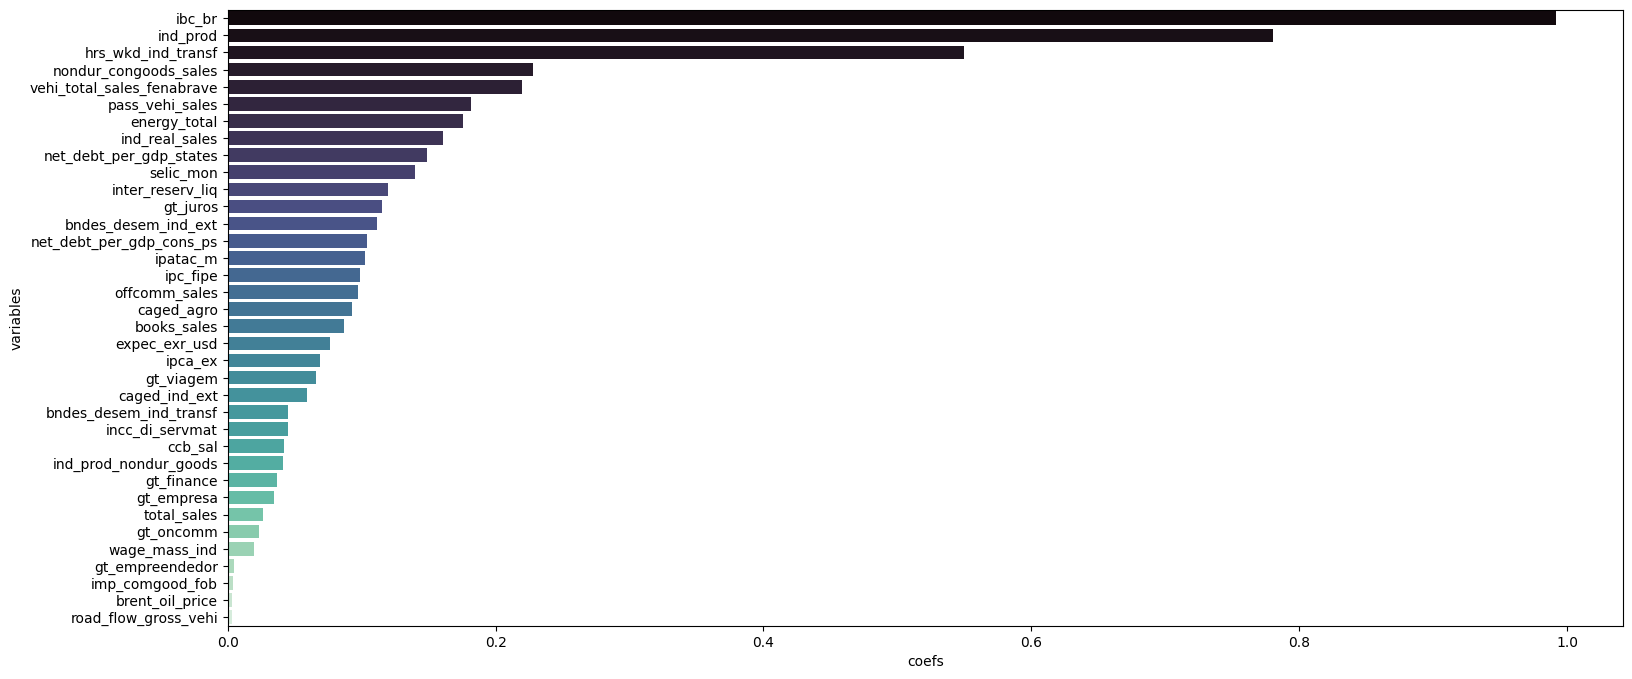

In [10]:
selected_lasso = selected_lasso.query('coefs > 0')
selected_lasso = selected_lasso.sort_values(by = 'coefs', ascending = False)
plt.figure(figsize=(18,8))
sns.barplot(x = 'coefs', y = 'variables', data = selected_lasso, palette = 'mako')
plt.xticks(rotation = 0)
# plt.savefig('shrink-images/LASSO-selected-variables')

In [11]:
selected = list(selected_lasso['variables'])
selected.insert(0, 'gdp')
selected

['gdp',
 'ibc_br',
 'ind_prod',
 'hrs_wkd_ind_transf',
 'nondur_congoods_sales',
 'vehi_total_sales_fenabrave',
 'pass_vehi_sales',
 'energy_total',
 'ind_real_sales',
 'net_debt_per_gdp_states',
 'selic_mon',
 'inter_reserv_liq',
 'gt_juros',
 'bndes_desem_ind_ext',
 'net_debt_per_gdp_cons_ps',
 'ipatac_m',
 'ipc_fipe',
 'offcomm_sales',
 'caged_agro',
 'books_sales',
 'expec_exr_usd',
 'ipca_ex',
 'gt_viagem',
 'caged_ind_ext',
 'bndes_desem_ind_transf',
 'incc_di_servmat',
 'ccb_sal',
 'ind_prod_nondur_goods',
 'gt_finance',
 'gt_empresa',
 'total_sales',
 'gt_oncomm',
 'wage_mass_ind',
 'gt_empreendedor',
 'imp_comgood_fob',
 'brent_oil_price',
 'road_flow_gross_vehi']

# Tirando as variáveis não selecionadas e salvando o dataframe final

In [12]:
target_data = data[selected].copy()
target_data.to_csv('../../../data/data_target_lasso_full_tf12.csv')
# target_data.to_excel('../../../data/data_target_lasso_gtcat_tf12.xlsx')
target_data

,gdp,ibc_br,ind_prod,hrs_wkd_ind_transf,nondur_congoods_sales,vehi_total_sales_fenabrave,pass_vehi_sales,energy_total,ind_real_sales,net_debt_per_gdp_states,...,ind_prod_nondur_goods,gt_finance,gt_empresa,total_sales,gt_oncomm,wage_mass_ind,gt_empreendedor,imp_comgood_fob,brent_oil_price,road_flow_gross_vehi
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,NaN,2.45,0.7,0.0,2.51,6619.0,3993.0,976.0,0.7,0.005,...,0.5,1.75,-1.125,3.33,0.125,0.0,-0.250,-0.359005,0.013375,-0.04
2002-02-01,NaN,2.45,0.7,0.0,2.51,6619.0,3993.0,976.0,0.7,0.005,...,0.5,1.75,-1.125,3.33,0.125,0.0,-0.250,-0.359005,0.013375,-0.04
2002-03-01,NaN,2.45,0.7,0.0,2.51,6619.0,3993.0,976.0,0.7,0.005,...,0.5,1.75,-1.125,3.33,0.125,0.0,-0.250,-0.359005,0.013375,-0.04
2002-04-01,NaN,2.45,0.7,0.0,2.51,6619.0,3993.0,976.0,0.7,0.005,...,0.5,1.75,-1.125,3.33,0.125,0.0,-0.250,-0.359005,0.013375,-0.04
2002-05-01,NaN,2.45,0.7,0.0,2.51,6619.0,3993.0,976.0,0.7,0.005,...,0.5,1.75,-1.125,3.33,0.125,0.0,-0.250,-0.359005,0.013375,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,NaN,5.07,-0.3,3.1,-0.45,-1550.0,-3180.0,1229.0,0.7,0.120,...,3.4,0.50,-2.125,-0.16,1.375,1.5,-6.625,-90.055103,0.013375,-1.99
2022-06-01,0.036869,4.44,-0.6,3.4,2.11,-4361.0,288.0,318.0,1.2,0.430,...,4.0,-9.75,2.375,-0.13,0.750,1.7,2.000,93.031865,0.050027,-2.64
2022-07-01,NaN,6.44,-0.4,1.8,-0.27,6549.0,11945.0,1008.0,-1.7,0.060,...,4.0,-4.00,-1.750,-5.58,0.625,6.4,2.250,-111.393375,-0.041808,1.44


In [13]:
final_cols = list(target_data.columns)
final_cols

['gdp',
 'ibc_br',
 'ind_prod',
 'hrs_wkd_ind_transf',
 'nondur_congoods_sales',
 'vehi_total_sales_fenabrave',
 'pass_vehi_sales',
 'energy_total',
 'ind_real_sales',
 'net_debt_per_gdp_states',
 'selic_mon',
 'inter_reserv_liq',
 'gt_juros',
 'bndes_desem_ind_ext',
 'net_debt_per_gdp_cons_ps',
 'ipatac_m',
 'ipc_fipe',
 'offcomm_sales',
 'caged_agro',
 'books_sales',
 'expec_exr_usd',
 'ipca_ex',
 'gt_viagem',
 'caged_ind_ext',
 'bndes_desem_ind_transf',
 'incc_di_servmat',
 'ccb_sal',
 'ind_prod_nondur_goods',
 'gt_finance',
 'gt_empresa',
 'total_sales',
 'gt_oncomm',
 'wage_mass_ind',
 'gt_empreendedor',
 'imp_comgood_fob',
 'brent_oil_price',
 'road_flow_gross_vehi']

# Verificando os grupos de variáveis

In [14]:
series = list(target_data.columns)
n_series = np.arange(0, (target_data.shape[1]))
series_df = pd.DataFrame(n_series, index = series)

In [15]:
# Criando df para mapear grupo no dataframe de contribuição dos componentes

map_comp = meta_data[['category', 'name_df']].copy()
map_comp.set_index('name_df', inplace = True)
map_comp = map_comp.iloc[1:]

robust_data = pd.merge(series_df, map_comp, left_index=True, right_index=True)
robust_data['category'].value_counts()

Vendas                 6
Google Trends          6
Preços                 6
Produção               5
Mercado de Trabalho    4
Financeiras            4
Setor Público          2
Energia                1
Expectativas           1
Setor Externo          1
Name: category, dtype: int64